In [54]:
%pylab inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import DifferentiableHOS as DHOS
import flowpm
import pickle
import flowpm.tfpower as tfpower
import flowpm.scipy.interpolate as interpolate
from flowpm.tfpower import linear_matter_power
import jax
from flowpm import tfpm
import jax_cosmo as jc
from DifferentiableHOS.pk import pk as pkl
import jax_cosmo.power as power

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/common/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['power', 'figsize', 'pi']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [55]:
box_size=128.     # Transverse comoving size of the simulation volume
nc = 128          # Number of transverse voxels in the simulation volume
field_size = 5.   # Size of the lensing field in degrees
nsteps=40
B=2

In [56]:
cosmology = flowpm.cosmology.Planck15()

In [57]:
stages = np.linspace(0.1, 1., nsteps, endpoint=True)

# Create some initial conditions
k = tf.constant(np.logspace(-4, 1, 512), dtype=tf.float32)
pk = linear_matter_power(cosmology, k)
pk_fun = lambda x: tf.cast(tf.reshape(interpolate.interp_tf(tf.reshape(tf.cast(x, tf.float32), [-1]), k, pk), x.shape), tf.complex64)
initial_conditions = flowpm.linear_field(
      [nc, nc, nc],
      [box_size, box_size, box_size],
      pk_fun,
      batch_size=1)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)


In [58]:
 # Run the Nbody
states2 = flowpm.nbody(cosmology,
                        initial_state,
                    stages, [nc, nc, nc],
                    pm_nc_factor=B,
                    return_intermediate_states=True)

In [59]:
PGD_param=pickle.load( open("/global/u1/d/dlan/flowpm/notebooks/pgd_params/pgd_params_2_1_40.pkl", "rb" ) )

In [161]:
#alpha0=PGD_param['alpha0']
alpha0=0.01
mu=PGD_param['mu']
kl=PGD_param['kl']/(nc*B/ box_size)
ks=PGD_param['ks']/(nc*B/ box_size)

In [ ]:
pk_array=[]
pk_array1=[]
pk_jax=[]
for i in range(len(states2)):
    print(i)
    alpha=alpha0*states2[i][0]**mu
    dx=tfpm.PGD_correction(states2[i][1],[nc,nc,nc],alpha,kl,ks,pm_nc_factor=B)
    new_state= states2[i][1][0]+dx
    final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), new_state)
    final_field=tf.reshape(final_field, [nc, nc, nc])
    k, power_spectrum = pkl(final_field,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                            box_size]),kmin=0.1,dk=2*np.pi/box_size)
    final_field1 = flowpm.cic_paint(tf.zeros_like(initial_conditions), states2[i][1][0])
    final_field1=tf.reshape(final_field1, [nc, nc, nc])
    k1, power_spectrum1 = pkl(final_field1,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                         box_size]),kmin=0.1,dk=2*np.pi/box_size)

    pk_array.append(power_spectrum)
    pk_array1.append(power_spectrum1)
    pk_jax.append(power.nonlinear_matter_power(cosmo, k, states2[i][0]))

In [163]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

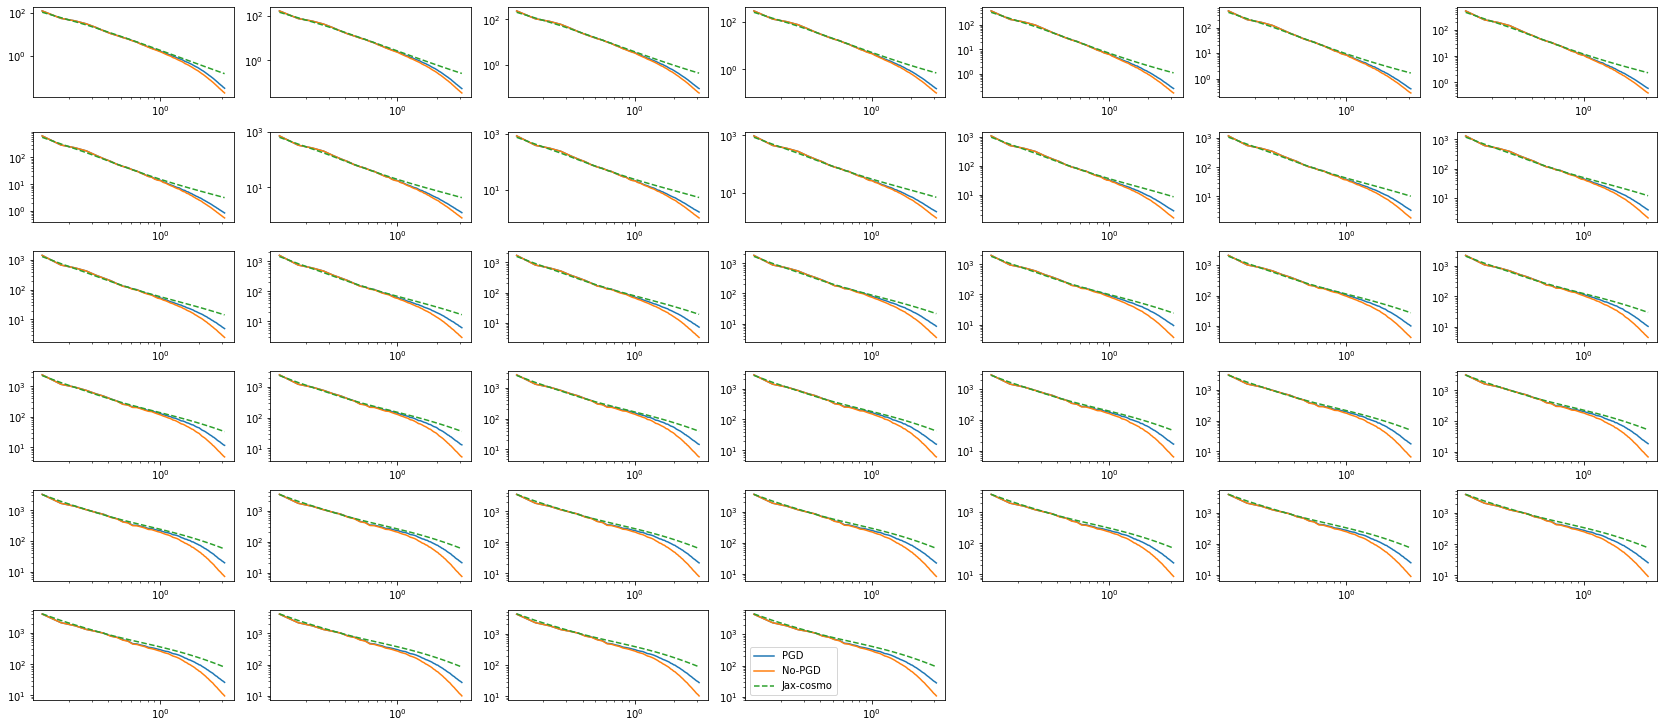

In [165]:
figsize = (23, 10)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 7
rows =6
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(pk_array))
# for ax, p in zip(axs, pk_array2):
#     #ax.set_title('markevery=%s' % str(case))
#     ax.loglog(k, p,label='Dif. Sim. B=2 ')
for ax, pi in zip(axs, pk_array):
    ax.loglog(k, pi,label='PGD')
for ax, px in zip(axs, pk_array1):
    ax.loglog(k, px,label='No-PGD')
for ax, pj in zip(axs, pk_jax):
    ax.loglog(k, pj,'--',label='Jax-cosmo')
legend(loc='lower left')
fig.savefig('png_B1.png',dpi=250)

# Exploring different alpha0

In [269]:
alpha_arr=[PGD_param['alpha0'], 0.01, 0.02, 0.03, 0.009,0.008,0.005]
mu=PGD_param['mu']
kl=PGD_param['kl']*0.7/(nc*B/ box_size)
ks=PGD_param['ks']*0.7/(nc*B/ box_size)

In [270]:
ps_alpha=[]
for i in alpha_arr:
    alpha=i*states2[-2][0]**mu
    dx=tfpm.PGD_correction(states2[-2][1],[nc,nc,nc],alpha,kl,ks,pm_nc_factor=B)
    new_state= states2[-2][1][0]+dx
    final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), new_state)
    final_field=tf.reshape(final_field, [nc, nc, nc])
    ps_alpha.append(pkl(final_field,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                            box_size]),kmin=0.1,dk=2*np.pi/box_size))

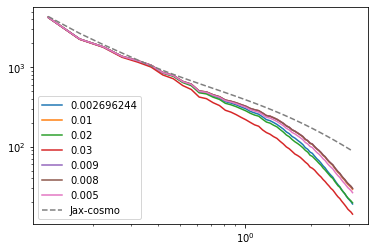

In [271]:
for i in range(len(ps_alpha)):
    loglog(ps_alpha[0][0],ps_alpha[i][1],label=str(alpha_arr[i]))
loglog(k, pk_jax[-2],'--',label='Jax-cosmo')
legend()
savefig('PDG*0.7.png',dpi=250)

# Trying different rescaling for kl and ks

In [275]:
mu=PGD_param['mu']
kl=PGD_param['kl']
ks=PGD_param['ks']
kl_array=[kl*0.7*0.5/(nc*B/ box_size),kl*0.5/(nc*B/ box_size),kl*2/(nc*B/ box_size),kl*2*0.7/(nc*B/ box_size) ]
ks_array=[ks*0.7*0.5/(nc*B/ box_size),ks*0.5/(nc*B/ box_size),ks*2/(nc*B/ box_size),ks*2*0.7/(nc*B/ box_size)]
alpha=PGD_param['alpha0']*states2[-2][0]**mu

ps_alpha2=[]
for i in range(len(kl_array)):
    dx=tfpm.PGD_correction(states2[-2][1],[nc,nc,nc],alpha,kl_array[i],ks_array[i],pm_nc_factor=B)
    new_state= states2[-2][1][0]+dx
    final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), new_state)
    final_field=tf.reshape(final_field, [nc, nc, nc])
    ps_alpha2.append(pkl(final_field,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                            box_size]),kmin=0.1,dk=2*np.pi/box_size))

In [279]:
legend_arr=['*0.7*0.5','*0.5','*2','*2*0.7']

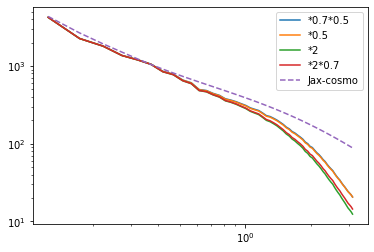

In [280]:
for i in range(len(kl_array)):
    loglog(ps_alpha2[0][0],ps_alpha2[i][1],label=legend_arr[i])
loglog(k, pk_jax[-2],'--',label='Jax-cosmo')
legend()
savefig('PDG*Vaness.png',dpi=250)

# Looking at the  PGD kernel 

<ipython-input-287-d31ce8b3575b>:3: RuntimeWarning: divide by zero encountered in true_divide
  plot(k,  np.exp(-kl_array[i]**2 / k**2) * np.exp(-k**4 / ks_array[i]**2),label=legend_arr[i])
<ipython-input-287-d31ce8b3575b>:3: RuntimeWarning: divide by zero encountered in true_divide
  plot(k,  np.exp(-kl_array[i]**2 / k**2) * np.exp(-k**4 / ks_array[i]**2),label=legend_arr[i])
<ipython-input-287-d31ce8b3575b>:3: RuntimeWarning: divide by zero encountered in true_divide
  plot(k,  np.exp(-kl_array[i]**2 / k**2) * np.exp(-k**4 / ks_array[i]**2),label=legend_arr[i])
<ipython-input-287-d31ce8b3575b>:3: RuntimeWarning: divide by zero encountered in true_divide
  plot(k,  np.exp(-kl_array[i]**2 / k**2) * np.exp(-k**4 / ks_array[i]**2),label=legend_arr[i])


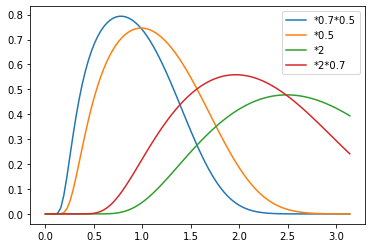

In [287]:
k = linspace(0, 3.14, 100)
for i in range(len(kl_array)):
    plot(k,  np.exp(-kl_array[i]**2 / k**2) * np.exp(-k**4 / ks_array[i]**2),label=legend_arr[i])
legend()
savefig('filter.png',dpi=250)